In [1]:
%load_ext autoreload
%autoreload 2
%aimport -torch

In [2]:
import torch
try:  
    # Attempt to disable torch.compile for faster iteration, but if it fails 
    # (probably due to older pytorch version) we just proceed anyway
    torch.compiler.set_stance("force_eager")
except:
    pass

from omegaconf import OmegaConf
from flowmo import train_utils
import mediapy, einops

/svl/u/kevin02/miniconda3/envs/FlowMo/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


""

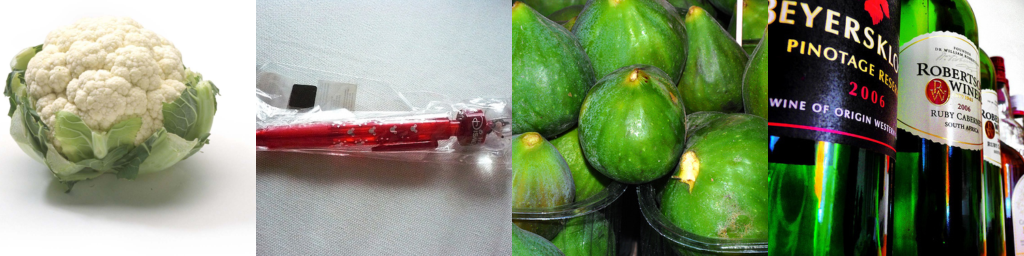

In [3]:
# Set up the data.
config = OmegaConf.load('flowmo/configs/base.yaml')
config.data.batch_size = 4
config.data.num_workers = 0

torch.manual_seed(3)
val_dataloader = train_utils.load_dataset(config, 'val', shuffle_val=True)
batch = next(train_utils.wrap_dataloader([next(iter(val_dataloader))]))

images = batch['image']
mediapy.show_image(einops.rearrange(images.cpu()/2+.5, "b c h w -> h (b w) c"), vmin=0, vmax=1)

In [4]:
# Choose your model
model_name = "flowmo_hi_qwen2.5-coder-0.5b"

# The low BPP model has 18 bits per token, the high bitrate model has 56 bits per token.
zoo = {
    "flowmo_lo": {"context_dim": 18, "ckpt_path": "flowmo_lo.pth"},
    "flowmo_hi": {"context_dim": 56, "ckpt_path": "flowmo_hi.pth"},
    "flowmo_hi_45000": {"context_dim": 56, "patch_size": 8, "mup_width": 4, "ckpt_path": "results/flowmo_hi_pretrain/checkpoints/00045000.pth"},
    "flowmo_hi_50000": {"context_dim": 56, "patch_size": 8, "mup_width": 4, "ckpt_path": "results/flowmo_hi_pretrain/checkpoints/00050000.pth"},
    "flowmo_hi_kl": {"context_dim": 768, "quantization_type": "kl", "code_length": 128, "patch_size": 8, "mup_width": 4, "ckpt_path": "results/flowmo_hi_kl_pretrain/checkpoints/00015000.pth"},
    "flowmo_hi_noop": {"context_dim": 768, "quantization_type": "noop", "code_length": 128, "patch_size": 8, "mup_width": 4, "ckpt_path": "results/flowmo_hi_noop_pretrain/checkpoints/00060000.pth"},
    "flowmo_hi_qwen2.5-coder-0.5b": {"context_dim": 896, "quantization_type": "qwen2.5-coder-0.5b", "code_length": 128, "patch_size": 8, "mup_width": 4, "ckpt_path": "results/flowmo_qwen2.5-coder-0.5b_pretrain/checkpoints/00070000.pth"},
}

if 'ckpt_path' in zoo[model_name]:
    state_dict = torch.load(zoo[model_name]['ckpt_path'], map_location='cuda')
config.model.context_dim = zoo[model_name]['context_dim']
if 'patch_size' in zoo[model_name]:
    config.model.patch_size = zoo[model_name]['patch_size']
if 'mup_width' in zoo[model_name]:
    config.model.mup_width = zoo[model_name]['mup_width']
if 'code_length' in zoo[model_name]:
    config.model.code_length = zoo[model_name]['code_length']
if 'quantization_type' in zoo[model_name]:
    config.model.quantization_type = zoo[model_name]['quantization_type']
config.model.codebook_size_for_entropy = 1  # don't need this at test time.
model = train_utils.build_model(config)
if 'ckpt_path' in zoo[model_name]:
    # Filter out keys starting with 'qwen_model'
    filtered_state_dict = {k: v for k, v in state_dict['model_ema_state_dict'].items() if not k.startswith('qwen_model')}
    # Load the filtered state dict, ignoring missing keys (like the qwen_model ones)
    model.load_state_dict(filtered_state_dict, strict=False)

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Mup enabled!


""

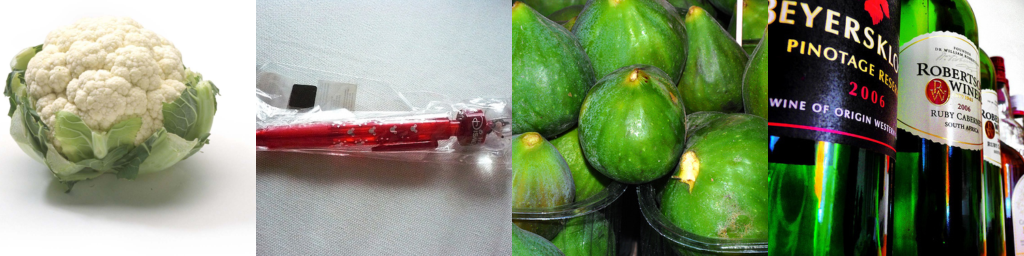

""

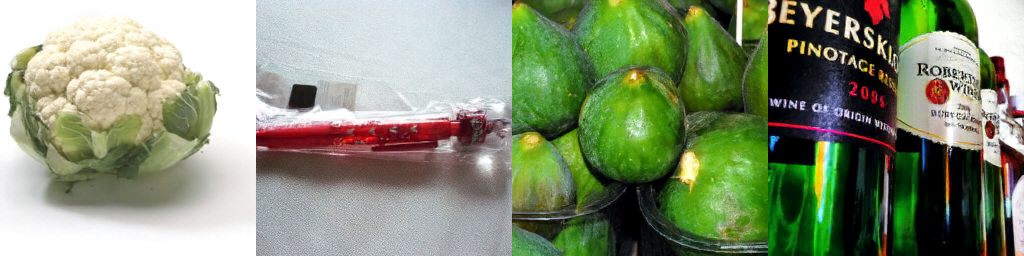

In [5]:
# Reconstruct the images. If you want to use your own images, FlowMo accepts
# images in [-1, 1] in bchw format.

model.eval()
with torch.no_grad(), torch.autocast('cuda', dtype=torch.bfloat16):
    images_rec = model.reconstruct(images)

# Show the original and reconstructed.
mediapy.show_image(einops.rearrange(images.cpu().numpy()/2+.5, "b c h w -> h (b w) c"))
mediapy.show_image(einops.rearrange(images_rec.cpu().numpy()/2+.5, "b c h w -> h (b w) c"))